<a href="https://colab.research.google.com/github/olcaykursun/ML/blob/main/neuralnets/AutoEncoders_with_DataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>AutoEncoders and Data Augmentation for Representation Learning in the Data Domain</b>  
AUM Machine Learning, Dr. Olcay Kursun, okursun@aum.edu  
Date: 04/11/2024 (Spring 2024)  

Description: This script demonstrates autoencoders and data augmentation. Autoencoders are adept at learning efficient representations (or encodings) of the input data by compressing it into a lower-dimensional space and then reconstructing it. This process forces the AutoEncoder to capture the most salient features of the data, which are essential for various tasks like classification, detection, or even generation within the image domain. Data Augmentation further enriches this learning process by introducing variations in the training data, which helps the model to generalize better by learning domain-specific robust features that are invariant to such changes.

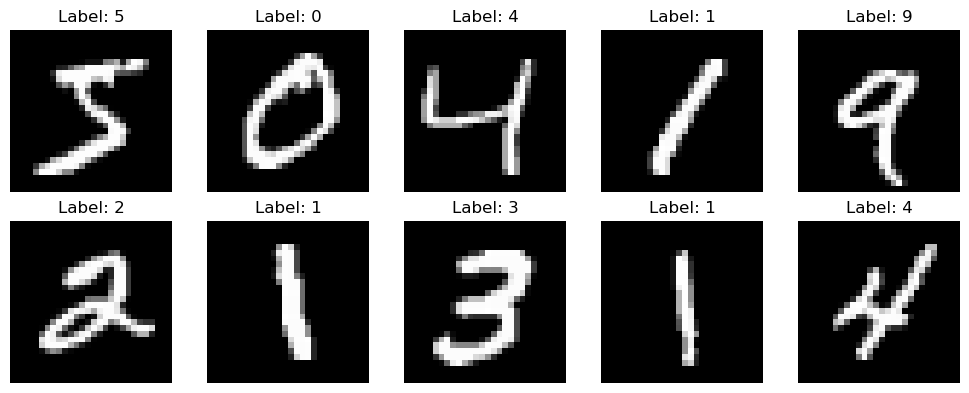

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data: Reshape and normalize
train_images = train_images.reshape((-1, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((-1, 28, 28, 1)).astype('float32') / 255

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Use a smaller subset for faster training
subset_indices = np.random.choice(train_images.shape[0], 500, replace=False)
train_images_subset = train_images[subset_indices]
train_labels_subset = train_labels[subset_indices]

# Function to display a grid of images
def display_images(images, labels, num_rows=2, num_cols=5):
    plt.figure(figsize=(10, 4))
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first few images and their labels
display_images(train_images, train_labels.argmax(axis=1))

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def create_model(use_augmentation=False):
    # Define the encoder
    input_img = layers.Input(shape=(28, 28, 1))

    if not use_augmentation:
        # Not using the data augmentation layers
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    else:
        # Using the data augmentation layers - by default applies only for fit/training and not for predict/inference
        x = layers.RandomRotation(factor=0.05)(input_img)  # Randomly rotate images in the range (-5% * 2pi, 5% * 2pi)
        x = layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))(x) # Random zoom-in zoom-out
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Define the decoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    # Extract the encoder
    encoder = Model(input_img, encoded)

    return autoencoder, encoder

In [ ]:
def create_classifier_using_encoded_features(encoder):
    encoded_input = layers.Input(shape=encoder.output_shape[1:])  # Use encoder's output shape, excluding the batch size
    x = layers.Flatten()(encoded_input)  # Flatten the encoded image

    # Build the classifier model
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    classifier_output = layers.Dense(10, activation='softmax')(x)  # For MNIST classification

    classifier_model = Model(encoded_input, classifier_output)
    classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return classifier_model

In [ ]:
def test_labeled_subset_with_encoded_features(encoder, classifier_model, test_images, test_labels):
    # Transform the test set through the encoder
    encoded_imgs_test = encoder.predict(test_images)

    # Evaluate the model on the test set
    return classifier_model.evaluate(encoded_imgs_test, test_labels)

In [ ]:
# Create and train the autoencoder without augmentation
autoencoder, encoder = create_model()
autoencoder.fit(train_images, train_images, epochs=10)

# Transform the labeled dataset
encoded_imgs = encoder.predict(train_images_subset)

# Create and train the classifier on the labeled dataset using the encoder
classifier_model = create_classifier_using_encoded_features(encoder)
classifier_model.fit(encoded_imgs, train_labels_subset, epochs=10)

# Test
test_loss, test_acc = test_labeled_subset_with_encoded_features(encoder, classifier_model, test_images, test_labels)
print(f"test loss without augmentation: {test_loss}")
print(f"test accuracy without augmentation: {test_acc}")

2024-04-11 00:45:10.549112: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-11 00:45:10.549134: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-11 00:45:10.549139: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-11 00:45:10.549169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-11 00:45:10.549187: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-04-11 00:45:10.960511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 22s 12ms/step - loss: 0.0847
Epoch 2/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0688
Epoch 3/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0669
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0659
Epoch 5/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0653
Epoch 6/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0649
Epoch 7/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0646
Epoch 8/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0643
Epoch 9/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0641
Epoch 10/10
16/16 [==============================] - 0s 2ms/step
Epoch 1/10
16/16 [==============================] - 0s 11ms/step - loss: 2.2277 - accuracy: 0.2640
Epoch 2/10
16/16 [==============================] - 0s 8ms/step - loss: 1.6846 - a

In [ ]:
classifier_model.fit(encoded_imgs, train_labels_subset, epochs=100, verbose=0)
test_loss, test_acc = test_labeled_subset_with_encoded_features(encoder, classifier_model, test_images, test_labels)
print(f"test loss with augmentation: {test_loss}")
print(f"test accuracy with augmentation: {test_acc}")

313/313 [==============================] - 2s 7ms/step - loss: 0.4537 - accuracy: 0.8885
test loss with augmentation: 0.45372137427330017
test accuracy with augmentation: 0.8884999752044678


In [ ]:
# Create and train the autoencoder with augmentation
autoencoder_aug, encoder_aug = create_model(use_augmentation=True)
autoencoder_aug.fit(train_images, train_images, epochs=10)

# Transform the labeled dataset
encoded_imgs_aug = encoder_aug.predict(train_images_subset)

# Create and train the classifier on the labeled dataset using the encoder
classifier_model_aug = create_classifier_using_encoded_features(encoder_aug)
classifier_model_aug.fit(encoded_imgs_aug, train_labels_subset, epochs=10)

# Test
test_loss, test_acc = test_labeled_subset_with_encoded_features(encoder_aug, classifier_model_aug, test_images, test_labels)
print(f"test loss with augmentation: {test_loss}")
print(f"test accuracy with augmentation: {test_acc}")

Epoch 1/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1531
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1374
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1332
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1307
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1288
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1269
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1253
Epoch 8/10
1875/1875 [==============================] - 27s 14ms/step - loss: 0.1235
Epoch 9/10
1875/1875 [==============================] - 29s 16ms/step - loss: 0.1217
Epoch 10/10
16/16 [==============================] - 0s 2ms/step
Epoch 1/10
16/16 [==============================] - 0s 10ms/step - loss: 2.2661 - accuracy: 0.1780
Epoch 2/10
16/16 [==============================] - 0s 9ms/step - loss:

In [ ]:
if 1: #train the autoencoder for some additional epochs
    autoencoder_aug.fit(train_images, train_images, epochs=100)
    encoded_imgs_aug = encoder_aug.predict(train_images_subset)

#train the classifier for some additional epochs
classifier_model_aug.fit(encoded_imgs_aug, train_labels_subset, epochs=10, verbose=0)
test_loss, test_acc = test_labeled_subset_with_encoded_features(encoder_aug, classifier_model_aug, test_images, test_labels)
print(f"test loss with augmentation: {test_loss}")
print(f"test accuracy with augmentation: {test_acc}")

313/313 [==============================] - 2s 7ms/step - loss: 0.2473 - accuracy: 0.9335
test loss with augmentation: 0.24732030928134918
test accuracy with augmentation: 0.9334999918937683
